In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
from scipy.optimize import minimize

In [2]:
sns.set()

[*********************100%***********************]  1 of 1 completed
d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\VaR\var.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of 

Likelihood Ratio Statistic: 7.5447
P-value: 0.0060
GEV model significantly improves the fit over Gumbel model.


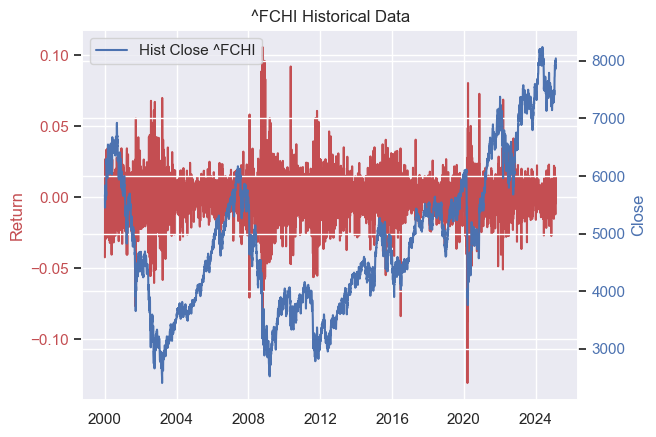

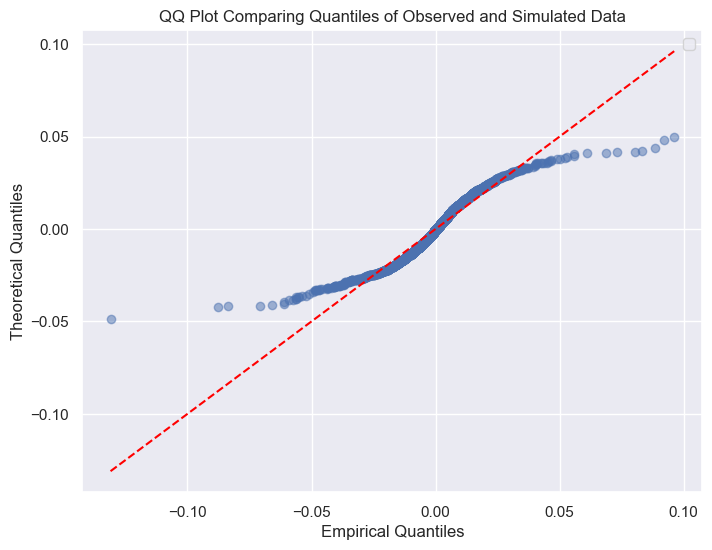

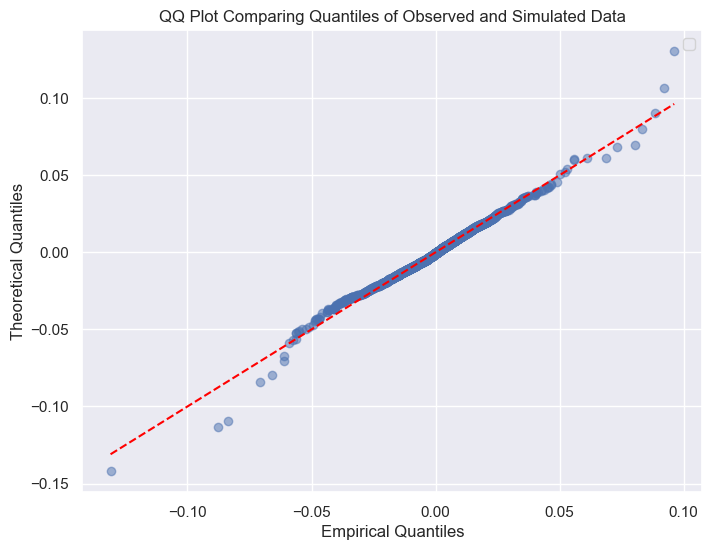

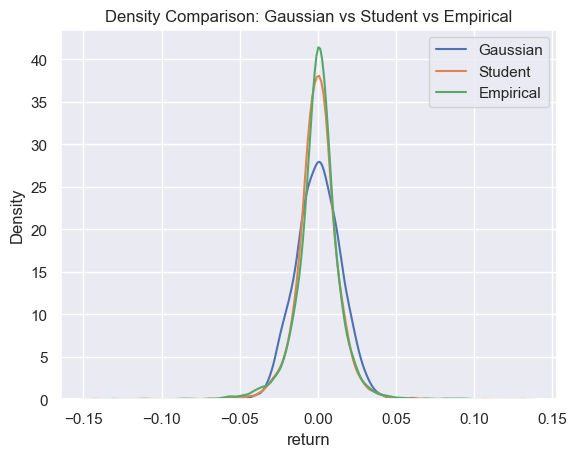

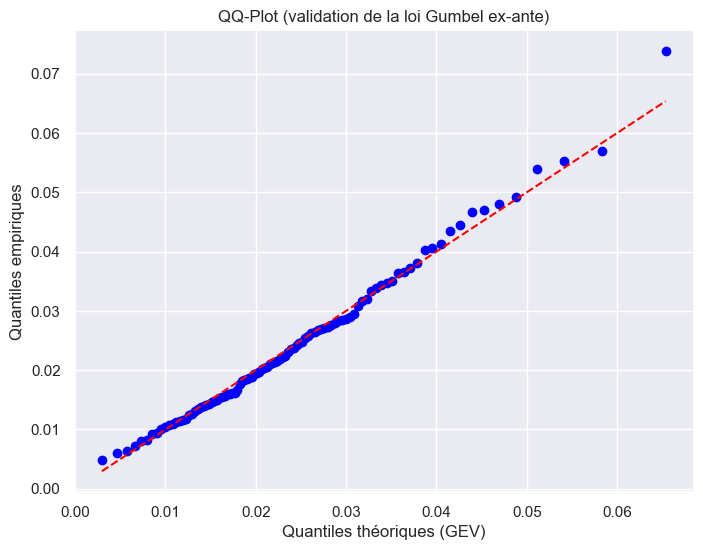

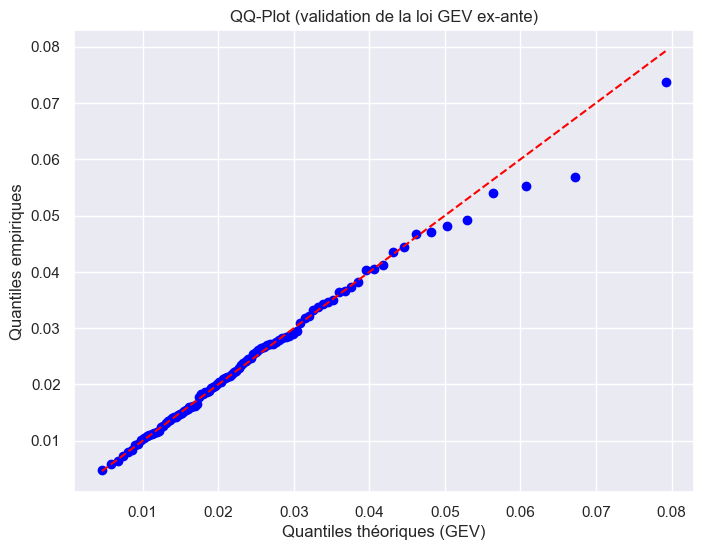

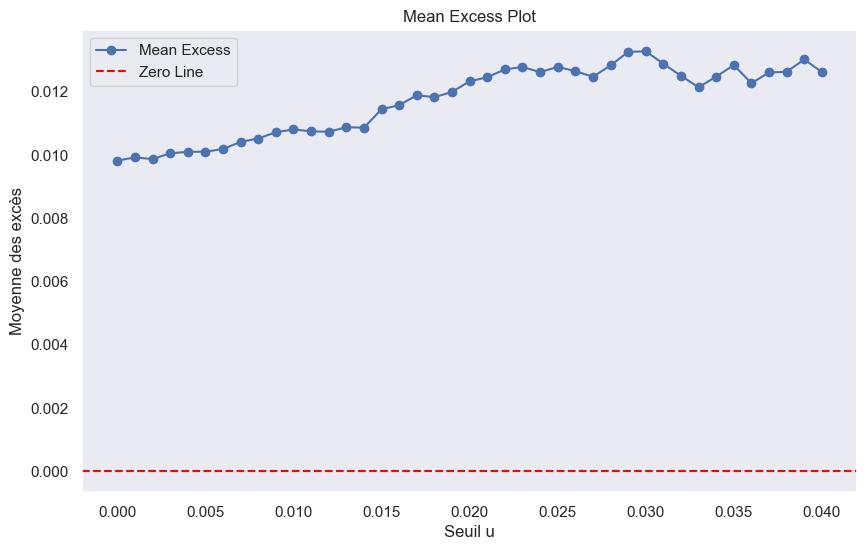

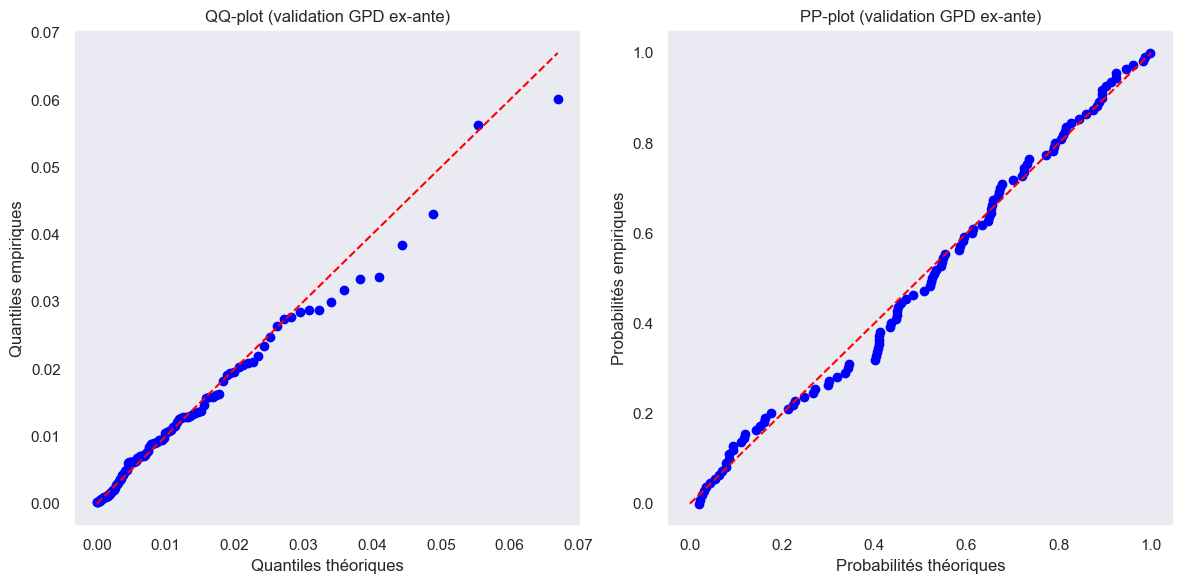

In [3]:
from var import Var


ticker = "^FCHI"
start_date = "2000-01-01"
end_date = pd.Timestamp(datetime.date.today())
start_train, start_test, end_test  = "2008-10-15", "2022-07-26", "2024-06-11"

VaR = Var(ticker, start_date, end_date)
result  = VaR.fit(start_train, start_test, end_test, alpha=0.99)


In [4]:
result

{'stats': {'Train set ':              Close       return
  count  3523.000000  3523.000000
  mean   4601.299644     0.000153
  std    1022.270616     0.013953
  min    2519.290039    -0.130983
  25%    3798.179932    -0.006099
  50%    4463.000000     0.000580
  75%    5318.609863     0.006855
  max    7376.370117     0.096169,
  'Test set':              Close      return
  count   481.000000  481.000000
  mean   7178.244013    0.000462
  std     589.667517    0.008819
  min    5676.870117   -0.036484
  25%    6850.470215   -0.004188
  50%    7260.729980    0.000753
  75%    7491.500000    0.005513
  max    8239.990234    0.041504},
 'VaR_hist': -0.040850308593776974,
 'VaR_bootstrap': -0.039431106131601355,
 'VaR_IC': {'VaR': -0.039431106131601355,
  'IC_lower_0.1': -0.05217446117911072,
  'IC_upper_0.9': -0.028913870967384958},
 'ES_hist': -0.05465890823555166,
 'VaR_gaussian': -0.03136832452284073,
 'VaR_gaussian_10_day': -0.0991953518754912,
 'ES_gaussian': -0.03556014243084804,
 '

# TVE

In [5]:

# Exemple d'utilisation :
data_train, data_test = VaR.train_test_split(start_train=start_train, start_test=start_test, end_test=end_test)

Afin de déterminer le seuil optimal, il ne doit pas être trop bas pour éviter d’inclure des données trop fréquentes, ni trop élevé afin de conserver suffisamment d'observations pour une modélisation fiable. Pour cette raison, un seuil minimal est fixé au quantile d'ordre 90% et un seuil maximal au quantile 99%. Avec un pas ajustable de 0.0001, nous explorons la plage de valeurs comprises entre u_min et u_max. Pour chaque seuil, nous estimons les paramètres de la loi GPD. Nous calculons ensuite les écarts absolus entre les estimations successives des paramètres scale et shape. Ces écarts sont additionnés pour chaque seuil afin de mesurer la stabilité des estimations. Le seuil optimal correspond à celui où la somme de ces écarts est minimale, indiquant une stabilité maximale des paramètres estimés.